In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
from tensorflow.keras import layers, models, Input

# Define the color map for the 8 classes
class_colors = {
    0: [0, 0, 0],  # Background clutter
    1: [128, 0, 0],  # Building
    2: [128, 64, 128],  # Road
    3: [0, 128, 0],  # Tree
    4: [128, 128, 0],  # Low vegetation
    5: [64, 0, 128],  # Moving car
    6: [192, 0, 192],  # Static car
    7: [64, 64, 0],  # Human
}


import numpy as np

def rgb_to_class_label_np(rgb_mask, class_mapping, color_threshold=30):
    label_mask = np.zeros((rgb_mask.shape[0], rgb_mask.shape[1]), dtype=np.uint8)
    
    for label, rgb in class_mapping.items():
        color_distances = np.sqrt(
            np.sum((rgb_mask - np.array(rgb)) ** 2, axis=-1)
        )
        
        mask = color_distances < color_threshold
        label_mask[mask] = label
    
    return label_mask


image_folder = "../input/imagedataset/IPProjectDataset24/train_data/Images"
mask_folder = "../input/imagedataset/IPProjectDataset24/train_data/Labels"

val_image_folder="../input/imagedataset/IPProjectDataset24/val_data/Images"
val_mask_folder = "../input/imagedataset/IPProjectDataset24/val_data/Labels"


image_paths = sorted(
    [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png'))])
mask_paths = sorted(
    [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder) if fname.endswith(('.jpg', '.png'))])

pillow_images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
pillow_masks = [Image.open(mask_path).convert('RGB') for mask_path in mask_paths] 


def preprocess_image(img, mask, target_size=(256, 256)):
    img = img.resize(target_size)
    mask = mask.resize(target_size)

    img = np.array(img) / 255.0  # Normalize to [0, 1]
    mask = np.array(mask)

    
    mask = rgb_to_class_label_np(mask,class_colors)

    return img, mask


processed_images = [preprocess_image(img, mask)[0] for img, mask in zip(pillow_images, pillow_masks)]
processed_masks = [preprocess_image(img, mask)[1] for img, mask in zip(pillow_images, pillow_masks)]


images = np.array(processed_images)
masks = np.array(processed_masks)


def get_augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Apply flips
        tf.keras.layers.RandomRotation(0.2),  # Apply rotations
        tf.keras.layers.RandomZoom(0.2)  # Apply zoom
    ])


def augment_image_and_mask(img, mask):
    mask_expanded = np.expand_dims(mask, axis=-1)
    
    image_aug_layer = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])
    
    mask_aug_layer = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])
    
    img_aug = image_aug_layer(tf.expand_dims(img, axis=0))[0]
    mask_aug = mask_aug_layer(tf.expand_dims(mask_expanded, axis=0))[0]
    
    mask_aug = mask_aug[..., 0]
    
    return img_aug, mask_aug


augmented_images, augmented_masks = [], []
for img, mask in zip(images, masks):
    img_aug, mask_aug = augment_image_and_mask(img, mask)
    augmented_images.append(img_aug)
    augmented_masks.append(mask_aug)

augmented_images_np = tf.stack(augmented_images).numpy()
augmented_masks_np = tf.stack(augmented_masks).numpy()

images = np.concatenate((images, augmented_images_np), axis=0)
masks = np.concatenate((masks, augmented_masks_np), axis=0)

val_image_paths = sorted(
    [os.path.join(val_image_folder, fname) for fname in os.listdir(val_image_folder) if fname.endswith(('.jpg', '.png'))])
val_mask_paths = sorted(
    [os.path.join(val_mask_folder, fname) for fname in os.listdir(val_mask_folder) if fname.endswith(('.jpg', '.png'))])

pillow_val_images = [Image.open(img_path).convert('RGB') for img_path in val_image_paths]
pillow_val_masks = [Image.open(mask_path).convert('RGB') for mask_path in val_mask_paths]

processed_val_images = [preprocess_image(img, mask)[0] for img, mask in zip(pillow_val_images, pillow_val_masks)]
processed_val_masks = [preprocess_image(img, mask)[1] for img, mask in zip(pillow_val_images, pillow_val_masks)]

val_images = np.array(processed_val_images)
val_masks = np.array(processed_val_masks)

print("Total validation images:", len(val_images))

Total validation images: 70


In [ ]:
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPool2D, Input, Conv2DTranspose, 
    Concatenate, Activation, Dropout, SeparableConv2D
)
from tensorflow.keras.models import Model

def double_conv_block(inputs, num_filters, use_separable=False, dropout_rate=0.3):
    ConvLayer = SeparableConv2D if use_separable else Conv2D
    x = ConvLayer(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x) 

    x = ConvLayer(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters, use_separable=False, dropout_rate=0.3):
    x = double_conv_block(inputs, num_filters, use_separable, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters, use_separable=False, dropout_rate=0.3):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = double_conv_block(x, num_filters, use_separable, dropout_rate)
    return x

def build_light_unet(input_shape, num_classes=8, use_separable=False, dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32, use_separable, dropout_rate) 
    s2, p2 = encoder_block(p1, 64, use_separable, dropout_rate)
    s3, p3 = encoder_block(p2, 128, use_separable, dropout_rate)
    s4, p4 = encoder_block(p3, 256, use_separable, dropout_rate)

    # Bridge
    b1 = double_conv_block(p4, 512, use_separable, dropout_rate)

    # Decoder
    d1 = decoder_block(b1, s4, 256, use_separable, dropout_rate)
    d2 = decoder_block(d1, s3, 128, use_separable, dropout_rate)
    d3 = decoder_block(d2, s2, 64, use_separable, dropout_rate)
    d4 = decoder_block(d3, s1, 32, use_separable, dropout_rate)

    # Output layer
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="Light_UNET")
    return model



input_shape = (256, 256, 3)
num_classes = 8 

model = build_light_unet(input_shape, num_classes, use_separable=True, dropout_rate=0.4)
model.summary()

In [4]:
num_of_classes =8
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate, Activation

def double_conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(inputs, num_filters):
  x = double_conv_block(inputs, num_filters)
  p = MaxPool2D((2,2))(x)

  return x, p

def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = double_conv_block(x, num_filters)

  return x


def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = double_conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer for 8 classes
    outputs = layers.Conv2D(num_of_classes, 1, padding="same", activation="softmax")(d4)
    model = models.Model(inputs, outputs, name="UNET")
    return model
input_shape = (256, 256, 3) 
model = build_unet(input_shape)
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_402     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_402[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_42[0][0] 

 Total params: 31,055,752 (118.47 MB)

 Trainable params: 31,043,976 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [5]:
model.compile(optimizer='adam',
               loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


model.fit(images, masks, epochs=200, validation_data=(val_images, val_masks))

Epoch 1/200


I0000 00:00:1734517772.999730      90 service.cc:145] XLA service 0x5c7091ba3370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734517772.999814      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734517772.999820      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734517773.966128      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734517898.525601      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.2661 - loss: 1.9286

W0000 00:00:1734517919.263366      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2710 - loss: 1.9162

W0000 00:00:1734517997.121882      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734517999.045233      87 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


13/13 ━━━━━━━━━━━━━━━━━━━━ 249s 9s/step - accuracy: 0.2752 - loss: 1.9056 - val_accuracy: 0.1155 - val_loss: 645.4075
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3780 - loss: 1.5640 - val_accuracy: 0.3329 - val_loss: 1743.2230
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3835 - loss: 1.5178 - val_accuracy: 0.3330 - val_loss: 1178.6173
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4055 - loss: 1.4471 - val_accuracy: 0.3326 - val_loss: 97.5031
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4061 - loss: 1.4216 - val_accuracy: 0.3336 - val_loss: 4.2764
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4224 - loss: 1.4032 - val_accuracy: 0.1475 - val_loss: 6.1026
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4560 - loss: 1.3258 - val_accuracy: 0.3830 - val_loss: 1.8441
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4401 - loss: 1.3460 - val_accuracy: 0.1968 - val

In [8]:
import numpy as np

def compute_confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    for true, pred in zip(y_true.flatten(), y_pred.flatten()):
        matrix[true, pred] += 1
    return matrix

def evaluate_model_extended(model, val_images, val_masks, num_classes=8):
    predictions = model.predict(val_images)
    predictions = np.argmax(predictions, axis=-1) 

    y_true = val_masks.flatten()
    y_pred = predictions.flatten()

    confusion = compute_confusion_matrix(y_true, y_pred, num_classes)

    accuracy = np.sum(np.diag(confusion)) / np.sum(confusion) 

    iou_per_class = []
    for c in range(num_classes):
        intersection = confusion[c, c]
        union = (
            np.sum(confusion[c, :]) + np.sum(confusion[:, c]) - intersection
        )
        iou_per_class.append(intersection / union if union != 0 else 0)
    mean_iou = np.mean(iou_per_class)

    dice_per_class = []
    for c in range(num_classes):
        intersection = 2 * confusion[c, c]
        dice = intersection / (np.sum(confusion[c, :]) + np.sum(confusion[:, c]))
        dice_per_class.append(dice if np.sum(confusion[c, :]) != 0 else 0)
    mean_dice = np.mean(dice_per_class)

    precision_per_class = []
    recall_per_class = []
    for c in range(num_classes):
        tp = confusion[c, c]
        fp = np.sum(confusion[:, c]) - tp
        fn = np.sum(confusion[c, :]) - tp
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        precision_per_class.append(precision)
        recall_per_class.append(recall)

    mean_precision = np.mean(precision_per_class)
    mean_recall = np.mean(recall_per_class)

    total_pairs = len(y_true) * (len(y_true) - 1) / 2
    tp_fp_fn_tn = np.sum([np.sum(confusion[c, :]) * np.sum(confusion[:, c]) for c in range(num_classes)])
    adjusted_rand_index = (
        (total_pairs * np.sum(np.diag(confusion)) - tp_fp_fn_tn)
        / (total_pairs - tp_fp_fn_tn)
    )

    print("Evaluation Results:")
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU (Jaccard Index): {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall (Sensitivity): {mean_recall:.4f}")
    print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
    for i, (iou, dice, precision, recall) in enumerate(zip(iou_per_class, dice_per_class, precision_per_class, recall_per_class)):
        print(f"Class {i}: IoU: {iou:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

In [9]:
evaluate_model_extended(model, val_images, val_masks, num_classes=8)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 932ms/step
Evaluation Results:
Pixel Accuracy: 0.7491
Mean IoU (Jaccard Index): 0.4978
Mean Dice Coefficient: 0.6315
Mean Precision: 0.6624
Mean Recall (Sensitivity): 0.6352
Adjusted Rand Index: 6139143.8298
Class 0: IoU: 0.4430, Dice: 0.6140, Precision: 0.5728, Recall: 0.6615
Class 1: IoU: 0.7527, Dice: 0.8589, Precision: 0.9184, Recall: 0.8067
Class 2: IoU: 0.6340, Dice: 0.7760, Precision: 0.8174, Recall: 0.7386
Class 3: IoU: 0.6286, Dice: 0.7720, Precision: 0.7684, Recall: 0.7756
Class 4: IoU: 0.5347, Dice: 0.6968, Precision: 0.6395, Recall: 0.7655
Class 5: IoU: 0.5520, Dice: 0.7113, Precision: 0.6908, Recall: 0.7331
Class 6: IoU: 0.4220, Dice: 0.5935, Precision: 0.6021, Recall: 0.5852
Class 7: IoU: 0.0150, Dice: 0.0295, Precision: 0.2899, Recall: 0.0155


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


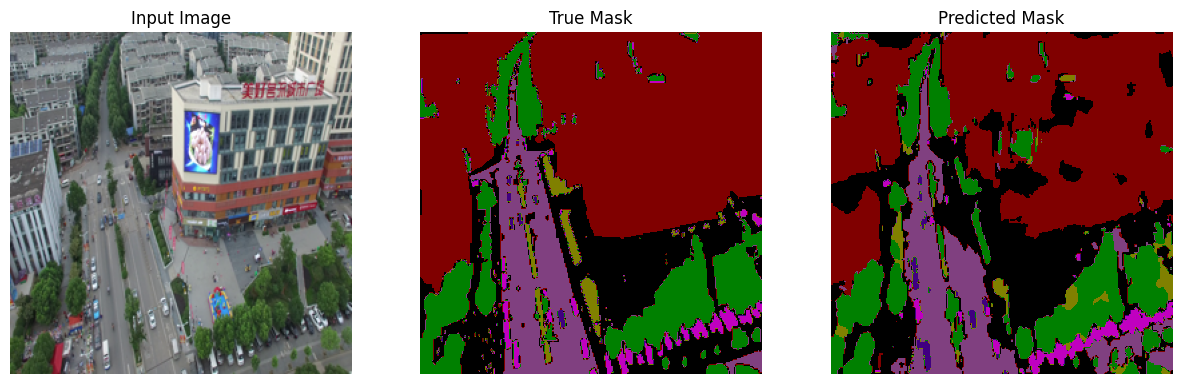

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


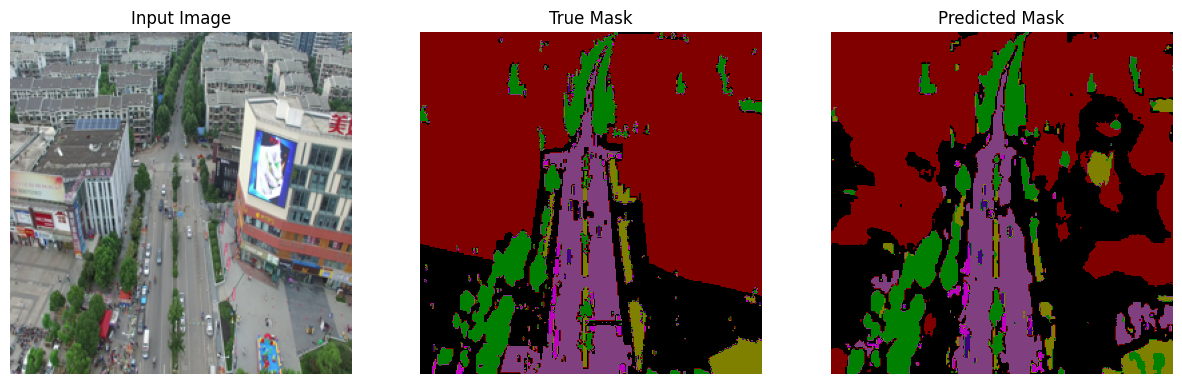

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


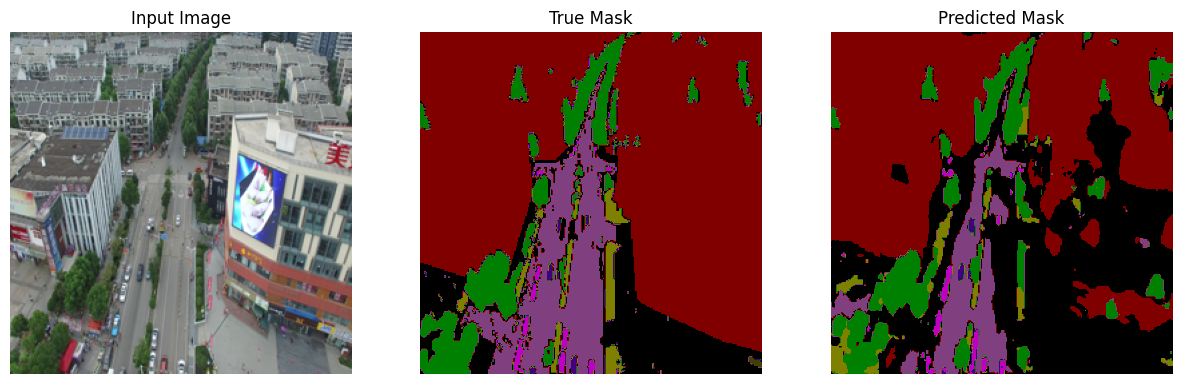

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


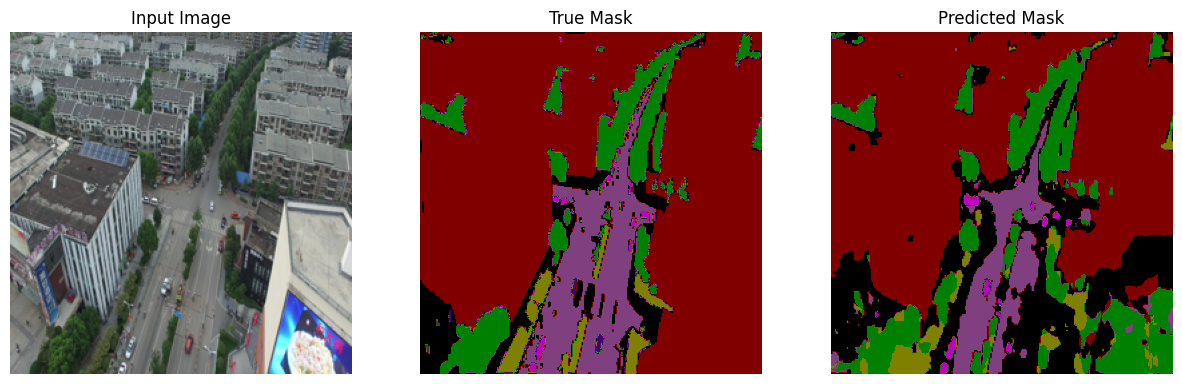

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


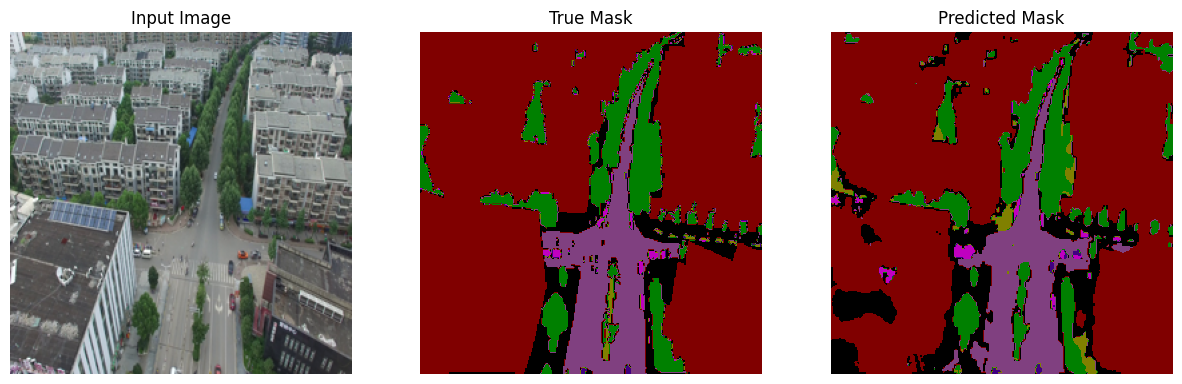

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


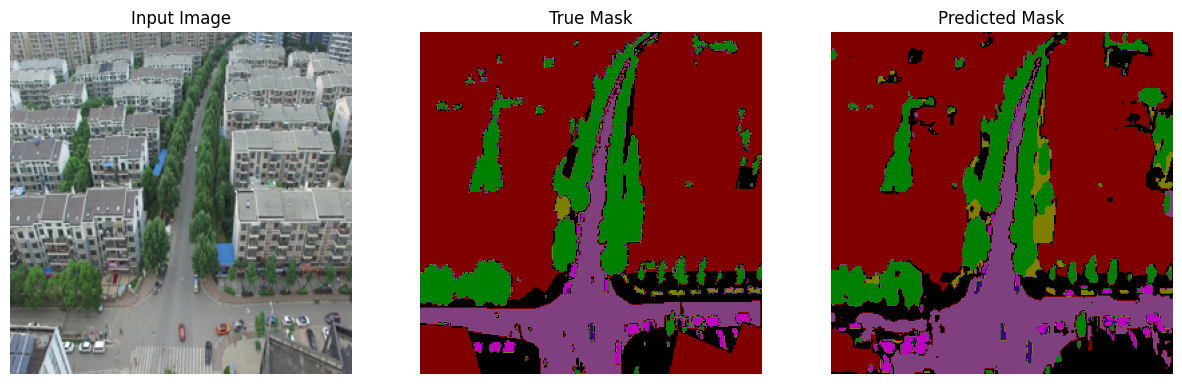

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


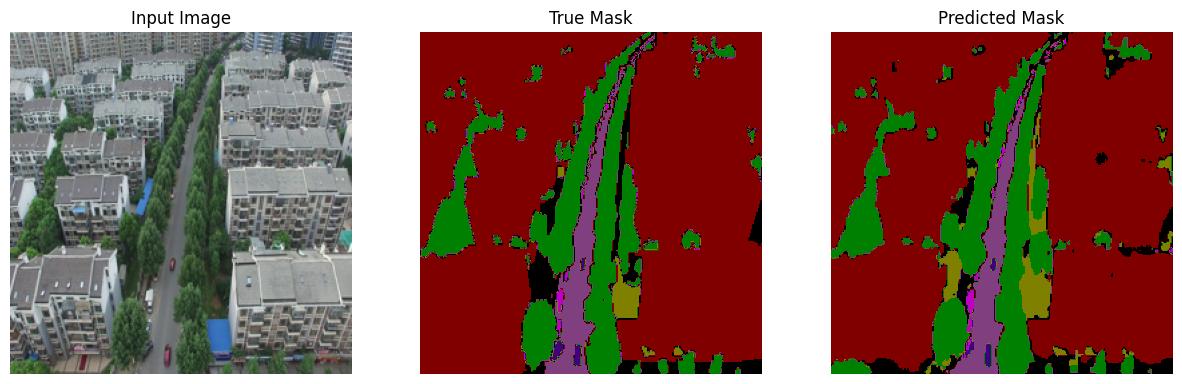

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


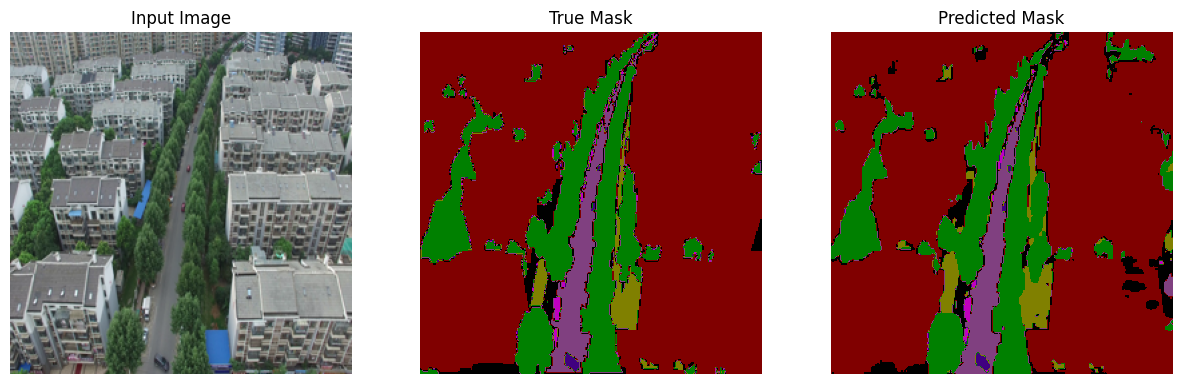

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


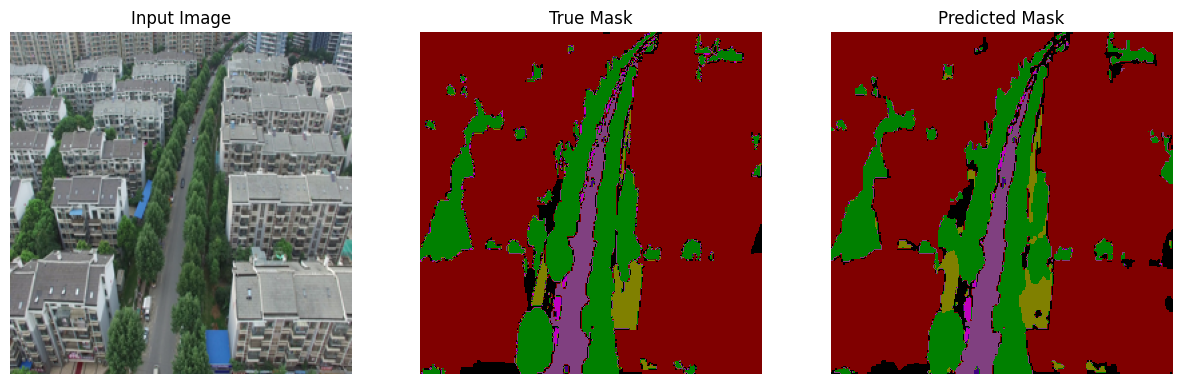

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


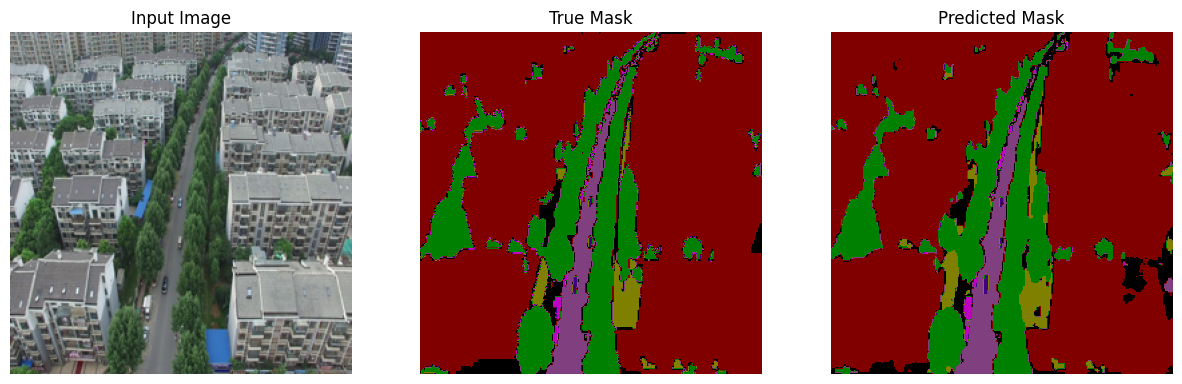

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1) 
    pred_mask = np.expand_dims(pred_mask, axis=-1) 
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))
    class_colors = [
    (0 / 255, 0 / 255, 0 / 255),         # Background clutter (Black)
    (128 / 255, 0 / 255, 0 / 255),       # Building (Dark Red)
    (128 / 255, 64 / 255, 128 / 255),    # Road (Purple)
    (0 / 255, 128 / 255, 0 / 255),       # Tree (Green)
    (128 / 255, 128 / 255, 0 / 255),     # Low vegetation (Yellow)
    (64 / 255, 0 / 255, 128 / 255),      # Moving car (Dark Violet)
    (192 / 255, 0 / 255, 192 / 255),     # Static car (Pinkish Violet)
    (64 / 255, 64 / 255, 0 / 255),       # Human (Brown)
]
    cmap = ListedColormap(class_colors)

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        
        item = display_list[i]
        if i == 0:  
            if item.max() <= 1.0:
                item = (item * 255).astype(np.uint8)
            else:
                item = item.astype(np.uint8)
        if len(item.shape) == 2:
            item = np.expand_dims(item, axis=-1)

        plt.imshow(item.astype(np.uint8),cmap=cmap) 
        plt.axis('off')
    plt.show()

def show_predictions(images=None, masks=None, num=1, model=None):
    """
    Displays the first image of each of the num batches
    Takes arrays of images and masks instead of a dataset
    """
    if images is not None and masks is not None:
        for i in range(num):
            image = images[i]
            mask = masks[i]
            image1 = np.expand_dims(image, axis=0) 
            pred_mask = model.predict(image1)
            display([image, mask, create_mask(pred_mask)])

# Example usage:
# Assuming `images_array` and `masks_array` are NumPy arrays of shape (num_images, height, width, channels)
show_predictions(val_images, val_masks, num=10, model=model)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, Activation, BatchNormalization, UpSampling2D, Multiply, Add
from tensorflow.keras.models import Model

# Define the Attention Gate
def attention_gate(skip_connection, gating_signal, num_filters):
    """
    Attention Gate (AG) to focus on relevant regions in skip connection.
    """
    theta_x = Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same')(skip_connection)
    theta_x = BatchNormalization()(theta_x)

    phi_g = Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same')(gating_signal)
    phi_g = BatchNormalization()(phi_g)

    add = Add()([theta_x, phi_g])
    relu = Activation('relu')(add)

    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(relu)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)

    attention_output = Multiply()([skip_connection, psi])

    return attention_output


def double_conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def encoder_block(inputs, num_filters):
    x = double_conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p


def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    
    # Apply attention gate to skip connection
    skip = attention_gate(skip, x, num_filters)
    
    x = Concatenate()([x, skip])
    x = double_conv_block(x, num_filters)

    return x


def build_attention_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = double_conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="Attention_U-Net")

    return model


input_shape = (256, 256, 3) 
num_classes = 8 
model = build_attention_unet(input_shape, num_classes)

model.summary()


In [ ]:

model.compile(optimizer='adam',
               loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

model.fit(images, masks, epochs=200, validation_data=(val_images, val_masks))

